In [518]:
# Use logistic regression to predict adult incomes
# Data resource: Kaggle (https://www.kaggle.com/flyingwombat/logistic-regression-with-uci-adult-income/data)

In [519]:
import numpy as np
import pandas as pd
import sklearn.preprocessing as preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.cross_validation as cross_validation
import sklearn.linear_model as linear_model
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [520]:
# Load local csv data into pandas DataFrame
income_df = pd.read_csv("data/income_data.csv")
income_df_list =  list(income_df)
print income_df_list
print income_df.shape

['age', 'workclass', 'fnlwgt', 'education', 'educational-num', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
(48842, 15)


In [521]:
income_df.sample(5)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
34190,50,Private,275181,5th-6th,3,Divorced,Other-service,Not-in-family,White,Male,0,0,37,Cuba,<=50K
48027,39,Private,42044,11th,7,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,<=50K
33947,59,Private,212783,HS-grad,9,Divorced,Other-service,Not-in-family,White,Female,0,0,38,United-States,<=50K
20320,35,Private,87556,HS-grad,9,Divorced,Craft-repair,Not-in-family,White,Male,0,0,40,United-States,<=50K
24843,49,Private,122066,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,30,Hungary,<=50K


In [522]:
# get some basic ideas about the data
def summerize_data_by_group(df):
    for column in df.columns:
        print column
        if df.dtypes[column] == np.object: # Categorical data
            print df[column].value_counts()
        else:
            print df[column].describe() 
            
        print '\n'
    
summerize_data_by_group(income_df) 

age
count    48842.000000
mean        38.643585
std         13.710510
min         17.000000
25%         28.000000
50%         37.000000
75%         48.000000
max         90.000000
Name: age, dtype: float64


workclass
Private             33906
Self-emp-not-inc     3862
Local-gov            3136
?                    2799
State-gov            1981
Self-emp-inc         1695
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: workclass, dtype: int64


fnlwgt
count    4.884200e+04
mean     1.896641e+05
std      1.056040e+05
min      1.228500e+04
25%      1.175505e+05
50%      1.781445e+05
75%      2.376420e+05
max      1.490400e+06
Name: fnlwgt, dtype: float64


education
HS-grad         15784
Some-college    10878
Bachelors        8025
Masters          2657
Assoc-voc        2061
11th             1812
Assoc-acdm       1601
10th             1389
7th-8th           955
Prof-school       834
9th               756
12th              657
Doctorate         594
5th-6t

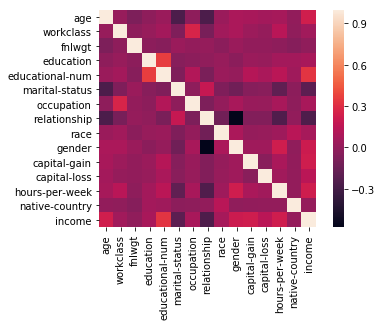

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
48837,27,4,257302,7,12,2,13,5,4,0,0,0,38,39,0
48838,40,4,154374,11,9,2,7,0,4,1,0,0,40,39,1
48839,58,4,151910,11,9,6,1,4,4,0,0,0,40,39,0
48840,22,4,201490,11,9,4,1,3,4,1,0,0,20,39,0
48841,52,5,287927,11,9,2,4,5,4,0,15024,0,40,39,1


In [523]:
# Encode the categorical features as numbers
def number_encode_features(df):
    result = df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = preprocessing.LabelEncoder()
            result[column] = encoders[column].fit_transform(result[column])
    return result, encoders


# Calculate the correlation and plot it
encoded_data, _ = number_encode_features(income_df)
sns.heatmap(encoded_data.corr(), square=True)
plt.show()

encoded_data.tail(5)

In [524]:
# Expore the strong correaltion between "education" and "education-num" revealed by the heatmap
income_df[["education", "educational-num"]].head(10)

,education,educational-num
0,11th,7
1,HS-grad,9
2,Assoc-acdm,12
3,Some-college,10
4,Some-college,10
5,10th,6
6,HS-grad,9
7,Prof-school,15
8,Some-college,10
9,7th-8th,4


In [525]:
# "education" and "education-num" are essentially the same data, delete the categorical one
del income_df["education"]

In [526]:
income_df.head(1) # Successfully deleted!

,age,workclass,fnlwgt,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K


In [527]:
# Check the negative correlation between "gender" and "relationship"
income_df[["gender", "relationship"]].head(10)

,gender,relationship
0,Male,Own-child
1,Male,Husband
2,Male,Husband
3,Male,Husband
4,Female,Own-child
5,Male,Not-in-family
6,Male,Unmarried
7,Male,Husband
8,Female,Unmarried
9,Male,Husband


In [528]:
# It looks like "Female" and "wife" and anti-correlated, so are "Male" and "Husband"

In [529]:
encoded_data, encoders = number_encode_features(income_df)
new_series = encoded_data["income"]

In [530]:
# Split and scale the data
X_train, X_test, y_train, y_test = cross_validation.train_test_split(encoded_data[encoded_data.columns.drop("income")], new_series, train_size=0.70)
scaler = preprocessing.StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = scaler.transform(X_test)

In [531]:
# logistic regression
cls = linear_model.LogisticRegression()

cls.fit(X_train, y_train)
y_pred = cls.predict(X_test)

In [532]:
print accuracy_score(y_test, y_pred)

0.8287040196546782


In [533]:
# Function to calculate mean absolute error
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

# Takes in a model, trains the model, and evaluates the model on the test set
def fit_and_evaluate(model):
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions and evalute
    model_pred = model.predict(X_test)
    model_mae = mae(y_test, model_pred)
    
    # Return the performance metric
    return model_mae

In [534]:
print fit_and_evaluate(cls)

0.17129598034532179


In [535]:
# Try random forest method
random_forest = RandomForestRegressor(random_state=60)

In [536]:
print fit_and_evaluate(random_forest)

0.191262312609


Index([u'age', u'workclass', u'fnlwgt', u'educational-num', u'marital-status',
       u'occupation', u'relationship', u'race', u'gender', u'capital-gain',
       u'capital-loss', u'hours-per-week', u'native-country'],
      dtype='object')


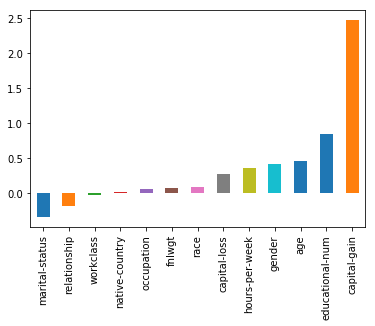

In [538]:
coefs = pd.Series(cls.coef_[0], index=X_train.columns)
print X_train.columns
coefs = coefs.sort_values()
plt.subplot(1,1,1)
coefs.plot(kind="bar")
plt.show()

In [539]:
# Try one hot encoding

# Copy the original data
features = income_df.copy()

# Select the numeric columns
numeric_subset = income_df.select_dtypes('number')
categorical_subset = income_df.select_dtypes('object')

# One hot encode
categorical_subset = pd.get_dummies(categorical_subset[categorical_subset.columns.drop("income")])

# Join the two dataframes using concat
# Make sure to use axis = 1 to perform a column bind
features = pd.concat([numeric_subset, categorical_subset], axis = 1)
print features.head()

   age  fnlwgt  educational-num  capital-gain  capital-loss  hours-per-week  \
0   25  226802                7             0             0              40   
1   38   89814                9             0             0              50   
2   28  336951               12             0             0              40   
3   44  160323               10          7688             0              40   
4   18  103497               10             0             0              30   

   workclass_?  workclass_Federal-gov  workclass_Local-gov  \
0            0                      0                    0   
1            0                      0                    0   
2            0                      0                    1   
3            0                      0                    0   
4            1                      0                    0   

   workclass_Never-worked            ...              native-country_Portugal  \
0                       0            ...                               

In [540]:
# Replace the inf with nan
features = features.replace({np.inf: np.nan, -np.inf: np.nan})

# Drop na values
features = features.dropna()

# Split and scale the data
X_train, X_test, y_train, y_test = cross_validation.train_test_split(features, new_series, train_size=0.70)
scaler = preprocessing.StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = scaler.transform(X_test)

In [541]:
cls = linear_model.LogisticRegression()

cls.fit(X_train, y_train)
y_pred = cls.predict(X_test)
print accuracy_score(y_test, y_pred)

0.8568211287790896


In [542]:
print fit_and_evaluate(cls)

0.1431788712209104


In [546]:
coefs = pd.Series(cls.coef_[0], index=X_train.columns)
print coefs.sort_values(ascending = False)

capital-gain                                 2.361560
marital-status_Married-civ-spouse            0.767016
educational-num                              0.723573
age                                          0.357221
hours-per-week                               0.351482
capital-loss                                 0.261972
occupation_Exec-managerial                   0.242488
relationship_Wife                            0.220325
occupation_Prof-specialty                    0.178282
gender_Male                                  0.174061
relationship_Not-in-family                   0.154106
workclass_Federal-gov                        0.106751
occupation_Tech-support                      0.099718
occupation_Sales                             0.086233
fnlwgt                                       0.080100
relationship_Unmarried                       0.076709
native-country_United-States                 0.070508
workclass_Private                            0.068592
occupation_Protective-serv  

In [ ]:
# Follow-up work: optimize the hyperparameters of random forest model
# Further group numerical predictors such as "age" or "hours-per-week" to gain more insight!